In [1]:
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.power import TTestIndPower
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.proportion import power_proportions_2indep
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from tqdm.notebook import tqdm
import seaborn as sns
import statsmodels as sm
import json
import itertools


import time
import sys
from collections import defaultdict
from scipy.stats import kurtosis
from scipy.stats import skew
from sklearn import preprocessing
import hashlib
np.random.seed(5)

plt.style.use('bmh')

In [2]:
titlesize = 15
labelsize = 15
legendsize = 12
xticksize = 15
yticksize = xticksize

plt.rcParams['legend.markerscale'] = 1.5     # the relative size of legend markers vs. original
plt.rcParams['legend.handletextpad'] = 0.5
plt.rcParams['legend.labelspacing'] = 0.4    # the vertical space between the legend entries in fraction of fontsize
plt.rcParams['legend.borderpad'] = 0.5       # border whitespace in fontsize units
plt.rcParams['font.size'] = 12
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['axes.labelsize'] = labelsize
plt.rcParams['axes.titlesize'] = titlesize
plt.rcParams['figure.figsize'] = (15, 6)
#plt.rcParams['image.cmap'] = 'tab20c'

plt.rc('xtick', labelsize=xticksize)
plt.rc('ytick', labelsize=yticksize)
plt.rc('legend', fontsize=legendsize)

In [6]:
# прогресс бар, почему-то в окружении гео стандартный пакеты типа tqdm не работают
def progressbar(it, prefix="", size=60, out=sys.stdout):
    count = len(it)
    def show(j):
        x = int(size*j/count)
        print("{}[{}{}] {}/{}".format(prefix, "#"*x, "."*(size-x), j, count), 
                end='\r', file=out, flush=True)
    show(0)
    for i, item in enumerate(it):
        yield item
        show(i+1)
    print("\n", flush=True, file=out)

In [7]:
def normalization_data(metric, sample_size):
    min_max_scaler = preprocessing.MinMaxScaler()
    normal_metric = min_max_scaler.fit_transform(metric.reshape(-1, 1))
    return np.reshape(normal_metric, (1, sample_size))

In [5]:
# генерируем датафрейм
sample_size = 100_000
MEAN = 3
STD = 1

metric = np.random.normal(MEAN, STD, sample_size).reshape(1, sample_size)
metric2 = np.random.normal(MEAN, STD, sample_size).reshape(1, sample_size)
log_metric = np.random.lognormal(MEAN, STD, sample_size).reshape(1, sample_size)
normal_metric = normalization_data(metric, sample_size)

user_id = np.arange(sample_size).reshape(1,sample_size)
starta_1 = np.random.randint(2, size=sample_size).reshape(1, sample_size)
starta_2 = np.random.randint(3, size=sample_size).reshape(1, sample_size)
cols = ['user_id', 'metric1', 'metric2', 'strata_1', 'strata_2']

df = pd.DataFrame(
    data=np.concatenate((user_id, metric, metric2, starta_1, starta_2), axis=0).T,
    columns=cols
    )
strat_columns = ['strata_1', 'strata_2']
df['strat_concat_column'] = df[strat_columns].astype('str').agg('-'.join, axis=1)
df['period'] = 'history'
df.head()

,user_id,metric1,metric2,strata_1,strata_2,strat_concat_column,period
0,0.0,3.441227,1.661769,1.0,2.0,1.0-2.0,history
1,1.0,2.669130,2.767098,1.0,2.0,1.0-2.0,history
2,2.0,5.430771,1.870762,1.0,0.0,1.0-0.0,history
3,3.0,2.747908,2.883268,1.0,2.0,1.0-2.0,history
4,4.0,3.109610,3.056127,0.0,2.0,0.0-2.0,history


In [85]:
# simple_ratio_metrics - простая ratio-метрика считается на основе одного показателя на пользователя 
# например, средний чек пользователя - сумма чеков за период по отношению к их количеству у одного пользователя
# все метрики заполняются в один подсловарь в виде 'metric1': ['sum', 'count'], где 1-ый элемент списка - знаменатель, второй - числитель
# user_metrics - простые пользовательские метрики, которые считаются до пользователя простой функцией
metric_dict = {
    'simple_ratio_metrics': {
        'is_simple_ratio': 1,
        'metric1': ['sum', 'count'],
        'metric2': ['sum', 'count']
    },
    'user_metrics': {
        'is_ratio': 0,
        'metric1': 'sum'
    }
}
# получаем информацию о том, какие метрики участвуют в эксперименте
# получаем информацию о том, по каким столбцам нужно группировать данные

In [ ]:
def get_simple_ratio_metrics(metric_dict):
    return {key:val for key,val in metric_dict['simple_ratio_metrics'].items() if isinstance(val, list)}

In [ ]:
def get_user_metrics(metric_dict):
    return {key:val for key,val in metric_dict['user_metrics'].items() if isinstance(val, str)}

In [131]:
simple_ratio_metrics = list(get_simple_ratio_metrics(metric_dict).keys())
user_metrics = list(get_user_metrics(metric_dict).keys())
all_metrics = set(simple_ratio_metrics + user_metrics)
column_for_grouped = [i for i in [col for col in df.columns] if i not in all_metrics]
column_for_grouped

['user_id', 'strata_1', 'strata_2', 'strat_concat_column', 'period']

In [109]:
def show_json(x):
    return print(json.dumps(x, indent=4))

In [137]:
# функции, которые помогают собрать словарь для агрегации сложной метрики, пока не исользуются
def get_metrics_set(metric_dict, func):
    return set(itertools.chain.from_iterable([func(i) for i in [k for i, k in metric_dict.items()]]))

def get_numerator_and_denominator_list(val):
    return [k for i, k in val.items() if (i == 'numerator') | (i == 'denominator')]

def get_numerator_and_denominator_func(val):
    return [k for i, k in val.items() if (i == 'numerator_func') | (i == 'denominator_func')]

def get_agg_dict(val):
    metrics = get_numerator_and_denominator_list(val)
    functions = get_numerator_and_denominator_func(val)
    return dict(zip(metrics, functions))

In [197]:
def linearization_agg(data, column_for_grouped, value_name):
    df_count_metric = data.groupby(column_for_grouped).agg({value_name: 'count'}).rename(columns={value_name: f'{value_name}_lin_count'}).reset_index()
    df_sum_metric = data.groupby(column_for_grouped).agg({value_name: 'sum'}).rename(columns={value_name: f'{value_name}_lin_sum'}).reset_index()
    df_lin = pd.merge(df_count_metric, df_sum_metric, how='inner', on=column_for_grouped).fillna(0)
    return df_lin

In [255]:
# решение для метрик - расчет пользовательских, ratio и линеаризованных в одном датафрейме
def calc_metrics(data, metric_dict, column_for_grouped, kappa=None, is_history_data=True):

    for metric_type, metric in metric_dict.items():
        if metric_type == 'simple_ratio_metrics':
            first_metric = True
            for key, val in metric.items():
                if isinstance(val, list):
                    # расчет ratio-метрики как она есть
                    agg_df = data.groupby(column_for_grouped).agg({key: val}).reset_index()
                    agg_df.columns = [''.join(col).strip() for col in agg_df.columns.values]
                    numerator = f'{key}{val[0]}'
                    denominator = f'{key}{val[1]}'
                    agg_df[f'{key}_ratio'] = agg_df[numerator] / agg_df[denominator]
                    ratio_columns = column_for_grouped + [f'{key}_ratio']

                    # расчет линеаризованной метрики
                    if kappa is None:
                        if is_history_data:
                            df_kappa = linearization_agg(data, column_for_grouped, key)
                        else:
                            control_df = data[data['group'] == control_group_name]
                            df_kappa = linearization_agg(control_df, column_for_grouped, key)
                        kappa = np.sum(df_kappa[f'{key}_lin_sum']) / np.sum(df_kappa[f'{key}_lin_count'])
                        #print('kappa is: ', kappa)
                    df_lin = linearization_agg(data, column_for_grouped, key)
                    df_lin[f'{key}_linear'] = df_lin[f'{key}_lin_sum'] - kappa * df_lin[f'{key}_lin_count']
                    linear_columns = column_for_grouped + [f'{key}_linear']
                    agg_df = pd.merge(agg_df[ratio_columns], df_lin[linear_columns], how='left', on=column_for_grouped)
                    all_columns = list(agg_df.columns)
                    if first_metric:
                        simple_ratio_metrics = agg_df[all_columns]
                        first_metric = False
                    else:
                        simple_ratio_metrics = pd.merge(simple_ratio_metrics, agg_df[all_columns], how='left', on=column_for_grouped)

        if metric_type == 'user_metrics':
            first_metric = True
            for key, val in metric.items():
                key, val
                if isinstance(val, str):
                    agg_df = data.groupby(column_for_grouped).agg({key: val}).rename(columns={key: f'{key}_sum'}).reset_index()
                    all_columns = list(agg_df.columns)
                    if first_metric:
                        user_metrics_df = agg_df[all_columns]
                        first_metric = False
                    else:
                        user_metrics_df = pd.merge(user_metrics_df, agg_df[all_columns], how='left', on=column_for_grouped)    
    res = pd.merge(user_metrics_df, simple_ratio_metrics, how='left', on=column_for_grouped)
    return res

In [256]:
calc_metrics(df, metric_dict, column_for_grouped, kappa=None, is_history_data=True)

,user_id,strata_1,strata_2,strat_concat_column,period,metric1_sum,metric1_ratio,metric1_linear,metric2_ratio,metric2_linear
0,0.0,1.0,2.0,1.0-2.0,history,3.441227,3.441227,0.437455,1.661769,-1.342004
1,1.0,1.0,2.0,1.0-2.0,history,2.669130,2.669130,-0.334642,2.767098,-0.236674
2,2.0,1.0,0.0,1.0-0.0,history,5.430771,5.430771,2.426999,1.870762,-1.133010
3,3.0,1.0,2.0,1.0-2.0,history,2.747908,2.747908,-0.255864,2.883268,-0.120504
4,4.0,0.0,2.0,0.0-2.0,history,3.109610,3.109610,0.105838,3.056127,0.052354
...,...,...,...,...,...,...,...,...,...,...
99995,99995.0,1.0,1.0,1.0-1.0,history,2.185538,2.185538,-0.818234,2.764030,-0.239742
99996,99996.0,0.0,2.0,0.0-2.0,history,3.201440,3.201440,0.197668,3.909444,0.905671
99997,99997.0,0.0,2.0,0.0-2.0,history,3.716781,3.716781,0.713009,4.467277,1.463505
99998,99998.0,0.0,1.0,0.0-1.0,history,4.423214,4.423214,1.419442,3.260377,0.256604


In [9]:
# добавка эффекта
def add_increment_strata(data, increment_abs, strata, metric_name):
    data.loc[data['strat_concat_column'].isin([strata]), metric_name] += increment_abs
    return

In [7]:
add_increment_strata(df, 2, '2.0-2.0', 'metric1')
add_increment_strata(df, 2, '1.0-2.0', 'metric1')
add_increment_strata(df, 2, '2.0-1.0', 'metric1')

In [8]:
# посмотрим на распределение сырых данных
def data_distribution_plot(metrics, verbose=True):
    
    fig, ax = plt.subplots()
    x = 0.02
    y = 0.65
    step_y = 0
    for hist in metrics:
        data_mean = round(np.mean(hist), 4)
        data_std = round(np.std(hist), 4)
        data_median = round(np.median(hist), 4)
        skewness_ = np.round(skew(hist), 4)
        kurtosis_ = np.round(kurtosis(hist), 4)
        lenght = len(hist)
        ax.hist(
            hist, 
            bins=300,
            alpha=0.5,
            density=True,
            label=[hist.name]
        )
        if verbose:
            props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)        

            textstr = '\n'.join((
                f'{hist.name}',
                r'$\mu=%.3f$' % (data_mean, ),
                r'$\mathrm{median}=%.3f$' % (data_median, ),
                r'$\sigma=%.3f$' % (data_std, ),
                r'$length=%.0f$' % (lenght, ),
                #r'$skewness=%.3f$' % (skewness_, ),
                #r'$kurtosis=%.3f$' % (kurtosis_, ),
                ))

            ax.text(x, y+step_y, textstr, transform=ax.transAxes, fontsize=10,
                    verticalalignment='top', bbox=props)
        step_y += 0.3
        ax.axvline(x = data_mean, ymin = 0, ymax = 0.90, linestyle='--', color='white', linewidth=0.5)
    plt.grid(color='grey', linestyle='--', linewidth=0.5)
    plt.legend(loc='upper right')
    plt.show()

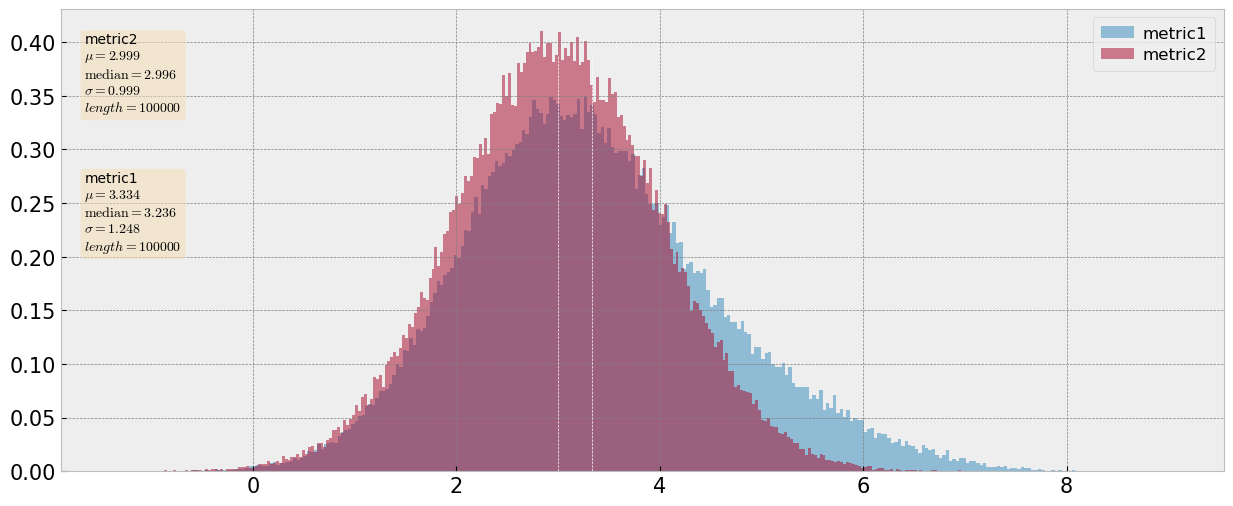

In [9]:
data_distribution_plot([df['metric1'], df['metric2']])

In [15]:
# TODO доработать функцию так, чтобы деление было на не равные группы или вынести это в другую функцию
def stratified_without_group(data, strata_list, group_size, weight, metric_name, strat_concat_column='strat_concat_column', group_count=1, larger_group_weight=0.5, verbose=False):
    strat_df = data[data[strat_concat_column].isin(strata_list)].reset_index(drop=True)
    one_group_size = int(round(group_size * weight)) * group_count
    try:
        random_indexes_for_one_group = np.random.choice([i for i in range(len(strat_df))], one_group_size, False)
    except ValueError:
        print('Объем выборки превышает объем входных данных.')
    random_strata_df = strat_df.iloc[random_indexes_for_one_group,:]
    strat_mean = random_strata_df.groupby('strat_concat_column')[metric_name].mean()[0] * weight
    strat_var = random_strata_df.groupby('strat_concat_column')[metric_name].var()[0] * weight
    if verbose:
        print(f'Размер датафрейма страты {val_list}: {len(strat_df)}')
        print(f'one_group_size страты {val_list}: {one_group_size}')
        print(f'Количество случайных индексов, всего: {len(random_indexes_for_one_group)}')
        print(f'Количество отобранных индексов: {len(random_indexes_for_one_group)}')
        print(f'Количество строк в датафрейме страты: {len(random_strata_df)}')
    return random_strata_df, strat_mean, strat_var


def get_stratified_data(data, group_size, metric_name, larger_group_weight=None, weights=None, seed=None, verbose=False):
    """
    Выравнивает общий датафрейм в соответствии с весами

    data - pd.DataFrame, датафрейм с описанием объектов, содержит атрибуты для стратификации.
    group_size - int, размер одной группы
    group_count - int, количество групп (по умолчанию 2)
    weights - dict, словарь весов страт {strat: weight}, где strat - либо tuple значений элементов страт,
        Если None, определить веса пропорционально доле страт в датафрейме data.
    seed - int, исходное состояние генератора случайных чисел для воспроизводимости
        результатов. Если None, то состояние генератора не устанавливается.

    return stratified_data - один датафрейм того же формата, что и data, колиество строк = group_size * group_count
    """
    np.random.seed(seed)
    
    stratified_df = pd.DataFrame(columns=data.columns)
    stratified_mean = []
    stratified_var = []
    if weights:
        for strata, weight in weights.items():
            strata_list = [strata]
            try:
                one_strata_df, one_strata_mean, one_strata_var = stratified_without_group(data, strata_list, group_size, weight, metric_name)
                stratified_df = pd.concat([stratified_df, one_strata_df], ignore_index=True)
                stratified_mean.append(one_strata_mean)
                stratified_var.append(one_strata_var)
            except UnboundLocalError:
                print('Нарушена индексация. Проверьте границы входимости индексов в датафрейм')
                return
    else:
        len_data = len(data)
        strat_dict = data.groupby('strat_concat_column').count().iloc[:,0].to_dict()
        strat_dict_shares = {strata:share/len_data for (strata, share) in strat_dict.items()}
        for strata, weight in strat_dict_shares.items():
            strata_list = [strata]
            try:
                one_strata_df, one_strata_mean, one_strata_var = stratified_without_group(data, strata_list, group_size, weight, metric_name)
                stratified_df = pd.concat([stratified_df, one_strata_df], ignore_index=True)
                stratified_mean.append(one_strata_mean)
                stratified_var.append(one_strata_var)
            except UnboundLocalError:
                print('Нарушена индексация. Проверьте границы входимости индексов в датафрейм')
                return  
    return stratified_df, sum(stratified_mean), sum(stratified_var)

In [16]:
def get_random_group(data, group_size, seed=None):
    np.random.seed(seed)
    random_indexes_for_one_group = np.random.choice([i for i in range(len(data))], group_size, False)
    return data.iloc[random_indexes_for_one_group,:]

In [18]:
#get_stratified_data(df_linear, 100000, 'metric2_linear', weights=None, seed=None)[0]
get_stratified_data(df_linear, 100000, 'metric1_linear', weights=None, seed=None)[1]
get_stratified_data(df_linear, 100000, 'metric1_linear', weights=None, seed=None)[2]

-1.6653345369377348e-16

1.004492720926247

In [20]:
#get_stratified_data(df_linear, 100000, 'metric2_linear', weights=None, seed=None)[0]
get_stratified_data(df_linear, 49_900, 'metric1_linear', weights=None, seed=None)[1]
get_stratified_data(df_linear, 49_900, 'metric1_linear', weights=None, seed=None)[2]

0.0034316599353940713

1.009055995395679

In [26]:
# test
random_mean = []
random_var = []

strat_mean = []
strat_var = []

n_iter = 2000

for i in progressbar(range(n_iter), "Computing: ", 40):
    
    random_group = get_random_group(df_linear, 10000)
    random_mean.append(random_group['metric1_linear'].mean())
    random_var.append(random_group['metric1_linear'].var())
    
    strat_mean.append(get_stratified_data(df_linear, 10000, 'metric1_linear', weights=None, seed=None)[1])
    strat_var.append(get_stratified_data(df_linear, 10000, 'metric1_linear', weights=None, seed=None)[2])
random_mean_series = pd.Series(random_mean, name='random mean metric')
strat_mean_series = pd.Series(strat_mean, name='strat mean metric')
random_var_series = pd.Series(random_var, name='random var metric')
strat_var_series = pd.Series(strat_var, name='strat var metric')

Computing: [########################################] 2000/2000



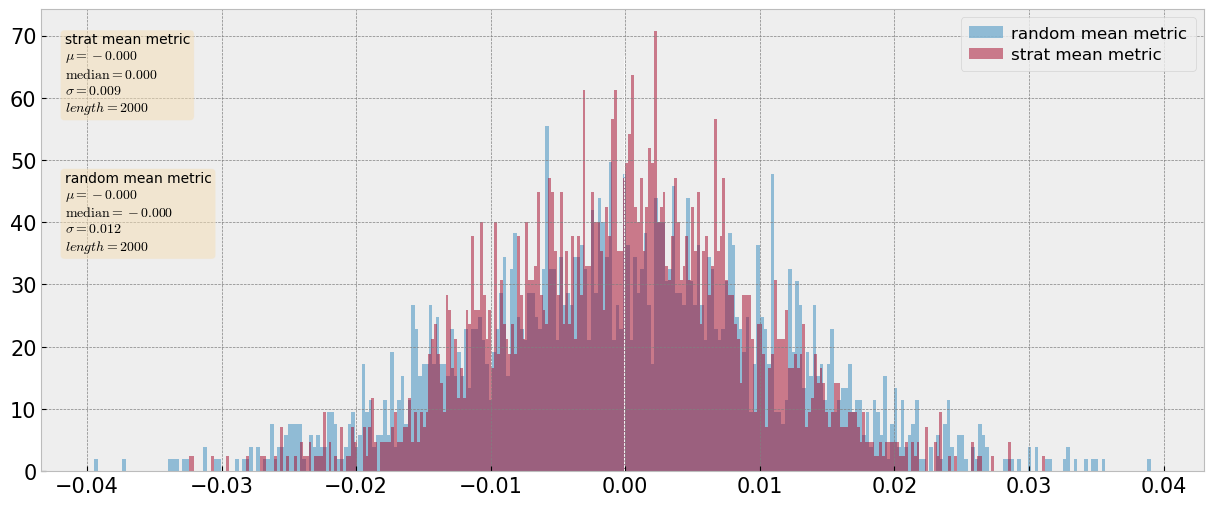

In [27]:
data_distribution_plot([random_mean_series, strat_mean_series])

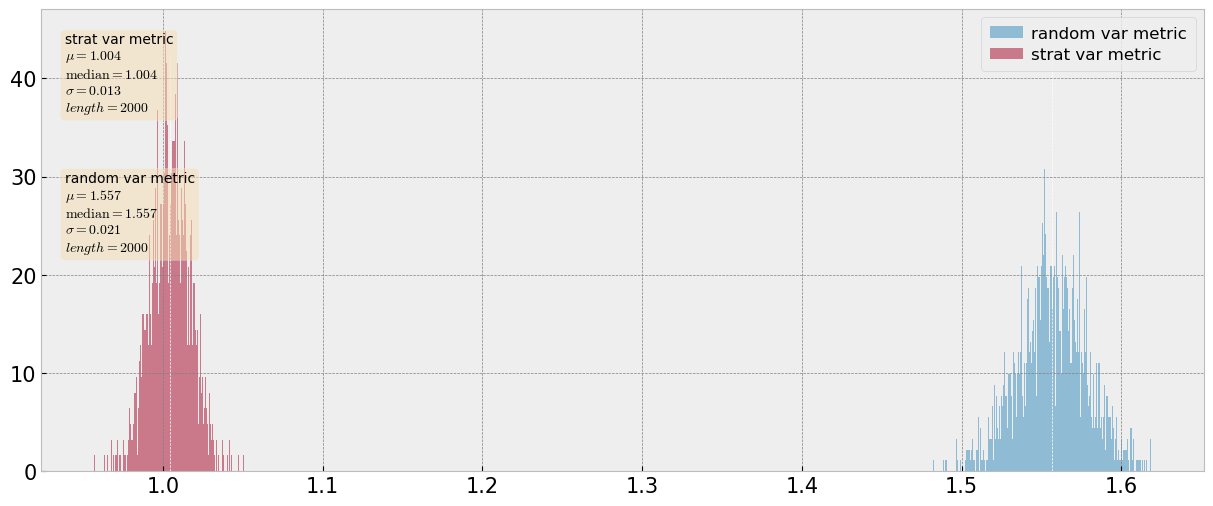

In [28]:
data_distribution_plot([random_var_series, strat_var_series])

In [276]:
MEAN = get_stratified_data(df_linear, 100_000, 'metric2_linear', weights=None, seed=None)[1]
STD = np.sqrt(get_stratified_data(df_linear, 100_000, 'metric2_linear', weights=None, seed=None)[2])
stratified_df = get_stratified_data(df_linear, 100_000, 'metric2_linear', weights=None, seed=None)[0]
EFFECT = 1.01
effect_bounds = np.linspace(1.01, 1.2, num=20)
sample_size_bounds = np.arange(1000, 10000, 500)
MEAN, STD

(6.106226635438361e-16, 0.9978912785713044)

In [277]:
stratified_df.shape

(100000, 9)

In [213]:
def get_sample_size_complex(mu: float=None,
                    std: float=None, 
                    mde: float=None, 
                    n_groups: int=2, 
                    target_share: float=0.5, 
                    r: float=1, 
                    alpha: float=0.05, 
                    beta: float=0.2
                   ) -> tuple[float, float]:
    """
    Возвращает sample_size для обычной пользовательской метрики, при заданных параметрах теста.
                                    ТАРГЕТНЫЕ ГРУППЫ ДОЛЖНЫ БЫТЬ РАВНЫ
    mu: среднее выборки на исторических данных
    std: стан. отклонение выборки на исторических данных
    n_groups: количество групп в тесте с учетом всех контрольных и таргетных
    target_share: доля одной таргетной группы
    r: отношение самой маленькой группы к самой большой группе
    alpha: уровень ошибки I рода
    beta: уровень ошибки II рода

    return: 
        sample_size: размер выборки для теста (включает в себя все группы)
    """
    
    t_alpha = stats.norm.ppf(1 - alpha / 2, loc=0, scale=1)
    t_beta = stats.norm.ppf(1 - beta, loc=0, scale=1)
    sample_ratio_correction = r + 2 + 1 / r
    comparisons = n_groups - 1
    mu_diff_squared = (mu - mu * mde)**2
    #print(mde-1, mu_diff_squared)
    sample_size = (
        sample_ratio_correction * (
            (t_alpha + t_beta)**2) * (std**2)
    ) / (
        mu_diff_squared * (1 - target_share * (comparisons - 1))
    )
    if n_groups == 2:
        return int(np.ceil(sample_size / 2)), 'complex'
    else:
        return int(np.ceil(sample_size)), 'complex'

In [278]:
def get_sample_size_standart(mu=None, std=None, mde=1.01, alpha=0.05, beta=0.2, n_groups=None, target_share=None, r=None):
    t_alpha = abs(norm.ppf(alpha / 2, loc=0, scale=1))
    t_beta = norm.ppf(1 - beta, loc=0, scale=1)
    
    mu_diff_squared = (mu - mu * mde) ** 2
    #print(eff, mu_diff_squared)
    z_scores_sum_squared = (t_alpha + t_beta) ** 2
    disp_sum = 2 * (std ** 2)
    sample_size = int(
        np.ceil(
            z_scores_sum_squared * disp_sum / mu_diff_squared
        )
    )
    return sample_size, 'standart'

In [279]:
def get_sample_size_matrix(sample_size_func, effect_bounds, n_groups=2, target_share=0.5, r=1, plot=True):
    res = []
    print(MEAN, STD)
    for eff in effect_bounds:
        sample_size, sample_size_method = sample_size_func(mu=MEAN, std=STD, mde=eff, n_groups=n_groups, target_share=target_share, r=r)
        res.append((eff, sample_size, sample_size_method))
    df_res = pd.DataFrame(res, columns=['effects', 'sample_size', 'calc_method'])
    if plot:
        sns.set_style("whitegrid")
        sns.lineplot(df_res, x='sample_size', y='effects', hue='calc_method')
        return
    else:
        return df_res

In [316]:
MEAN, STD = 3.339, 1.557
get_sample_size_matrix(get_sample_size_complex, effect_bounds, n_groups=2, target_share=0.5, r=1, plot=False)

3.339 1.56


,effects,sample_size,calc_method
0,1.01,34266,complex
1,1.02,8567,complex
2,1.03,3808,complex
3,1.04,2142,complex
4,1.05,1371,complex
5,1.06,952,complex
6,1.07,700,complex
7,1.08,536,complex
8,1.09,424,complex
9,1.10,343,complex


In [317]:
MEAN, STD = 3.339, 1.004
get_sample_size_matrix(get_sample_size_complex, effect_bounds, n_groups=2, target_share=0.5, r=1, plot=False)

3.339 0.997


,effects,sample_size,calc_method
0,1.01,13996,complex
1,1.02,3499,complex
2,1.03,1556,complex
3,1.04,875,complex
4,1.05,560,complex
5,1.06,389,complex
6,1.07,286,complex
7,1.08,219,complex
8,1.09,173,complex
9,1.10,140,complex


In [288]:
def get_MDE(mu: float=None,
            std: float=None, 
            sample_size: int=None, 
            n_groups: int=2, 
            target_share: float=0.5, 
            r: float=1, 
            alpha: float=0.05, 
            beta: float=0.2
           ) -> tuple[float, float]:
    """
    Возвращает MDE для обычной пользовательской метрики, при заданных параметрах теста. 
                                    ТАРГЕТНЫЕ ГРУППЫ ДОЛЖНЫ БЫТЬ РАВНЫ
    mu: среднее выборки на исторических данных
    std: стан. отклонение выборки на исторических данных
    sample size: размер выборки для теста (включает в себя все группы)
    n_groups: количество групп в тесте с учетом всех контрольных и таргетных
    target_share: доля одной таргетной группы
    r: отношение самой маленькой группы к самой большой группе
    alpha: уровень ошибки I рода
    beta: уровень ошибки II рода

    return: MDE abs и MDE в %
    """
    
    t_alpha = stats.norm.ppf(1 - alpha / 2, loc=0, scale=1)
    comparisons = n_groups - 1
    t_beta = stats.norm.ppf(1 - beta, loc=0, scale=1)
    sample_ratio_correction = r+2+1/r
    mde = np.sqrt(sample_ratio_correction)*(t_alpha + t_beta) * std / np.sqrt(sample_size*(1-target_share*(comparisons-1)))
    return mde, mde*100/mu

In [289]:
def get_effects_matrix(mde_func, sample_size_bounds, n_groups=2, target_share=0.5, r=1, plot=True):
    res = []
    #print(MEAN, STD)
    for size in sample_size_bounds:
        effect_abs, effect_percent = mde_func(mu=MEAN, std=STD, sample_size=size, n_groups=n_groups, target_share=target_share, r=r)
        res.append((size, effect_abs, effect_percent))
    df_res = pd.DataFrame(res, columns=['sample_size', 'effect_abs', 'effect_percent'])
    if plot:
        sns.set_style("whitegrid")
        sns.lineplot(df_res, x='sample_size', y='effects', hue='calc_method')
        return
    else:
        return df_res

In [295]:
MEAN * 1.23771855

38.49668785075085

In [296]:
MEAN + 7.393746

38.49668765886974

In [290]:
# control = 0.5, targets = [0.1, 0.1, 0.1, 0.1, 0.1],
get_effects_matrix(get_MDE, sample_size_bounds, plot=False)

,sample_size,effect_abs,effect_percent
0,1000,7.393746,23.771855
1,1500,6.036968,19.409638
2,2000,5.228168,16.809240
3,2500,4.676216,15.034641
4,3000,4.268781,13.724687
5,3500,3.952124,12.706591
6,4000,3.696873,11.885927
7,4500,3.485445,11.206160
8,5000,3.306584,10.631097
9,5500,3.152704,10.136353


In [366]:
def get_confidence_interval(mu, std, sample_size, confidence_level=0.95, tails = 2):
    """
    Вычисляет доверительный интервал.

    :return 
        (left_bound, right_bound): границы доверительного интервала.
    """
    
    significance_level = 1 - confidence_level
    cum_probability = 1 - (significance_level / tails)
    z_star = norm.ppf(cum_probability)
    
    left_bound = mu - z_star * std / np.sqrt(sample_size)    
    right_bound = mu + z_star * std / np.sqrt(sample_size)        
    return left_bound, right_bound

In [389]:
get_confidence_interval(MEAN, STD, len(stratified_df)/2, confidence_level=0.95, tails = 2)

(4.866946113613069, 4.993914557171714)

In [73]:
def get_stratified_with_groups(data, group_size, weights=None, seed=None):
    
    pilot = pd.DataFrame(columns=data.columns)
    control = pd.DataFrame(columns=data.columns)
    for strat, weight in weights.items():
        strat_df = data[data['strat_concat_column'].isin([strat])].reset_index(drop=True)
        ab_group_size = int(round(group_size * weight))
        random_indexes_ab = np.random.choice([i for i in range(len(strat_df))], ab_group_size * 2, False)
        a_indexes = random_indexes_ab[:ab_group_size]
        b_indexes = random_indexes_ab[ab_group_size:]
        a_random_strata_df = strat_df.iloc[a_indexes,:]
        b_random_strata_df = strat_df.iloc[b_indexes,:]
  
        control = pd.concat([control, a_random_strata_df], ignore_index=True)
        pilot = pd.concat([pilot, b_random_strata_df], ignore_index=True)
    
    control['group'] = 'control'
    pilot['group'] = 'pilot'
    
    return pd.concat([control, pilot]).reset_index()

def get_stratified_groups(data, group_size, weights=None, seed=None):
    """
    Подбирает стратифицированные группы для эксперимента из заранее подготовленной стратифицированной выборки

    data - pd.DataFrame, датафрейм с описанием объектов, содержит атрибуты для стратификации.
    strat_columns - List[str], список названий столбцов, по которым нужно стратифицировать.
    group_size - int, размеры групп.
    weights - dict, словарь весов страт {strat: weight}, где strat - либо tuple значений элементов страт,
        например, для strat_columns=['os', 'gender', 'birth_year'] будет ('ios', 'man', 1992), либо просто строка/число.
        Если None, определить веса пропорционально доле страт в датафрейме data.
    seed - int, исходное состояние генератора случайных чисел для воспроизводимости
        результатов. Если None, то состояние генератора не устанавливается.

    return (data_pilot, data_control) - два датафрейма того же формата, что и data
        c пилотной и контрольной группами.
    """
    np.random.seed(seed)
    
    pilot = pd.DataFrame(columns=strat_columns)
    control = pd.DataFrame(columns=strat_columns)
    if weights:
        df = get_stratified_with_groups(data, group_size, weights=None, seed=None)
        return df

    else:
        strat_dict = data.groupby('strat_concat_column').count().iloc[:,0].to_dict()
        len_data = len(data)
        strat_dict_shares = {strata:share/len_data for (strata, share) in strat_dict.items()}
        df = get_stratified_with_groups(data, group_size, weights=strat_dict_shares, seed=None)
        return df

In [76]:
get_stratified_groups(t[0], 100)

,index,user_id,metric1,metric2,strata_1,strata_2,strat_concat_column,group
0,0,4293.0,2.334558,3.160871,0.0,0.0,0.0-0.0,control
1,1,1044.0,3.167333,2.003382,0.0,0.0,0.0-0.0,control
2,2,928.0,2.280459,3.781898,0.0,0.0,0.0-0.0,control
3,3,8612.0,1.330889,3.476046,0.0,0.0,0.0-0.0,control
4,4,418.0,3.158065,2.050482,0.0,0.0,0.0-0.0,control
...,...,...,...,...,...,...,...,...
193,94,1291.0,2.289134,1.705008,4.0,2.0,4.0-2.0,pilot
194,95,725.0,3.756998,2.451575,4.0,2.0,4.0-2.0,pilot
195,96,1281.0,2.149162,1.458463,4.0,2.0,4.0-2.0,pilot
196,97,5379.0,3.742226,2.763053,4.0,2.0,4.0-2.0,pilot


In [82]:
get_stratified_groups(t[0], 100).groupby(['group', 'strat_concat_column']).count().iloc[:,0]

group    strat_concat_column
control  0.0-0.0                7
         0.0-1.0                7
         0.0-2.0                7
         1.0-0.0                6
         1.0-1.0                7
         1.0-2.0                7
         2.0-0.0                7
         2.0-1.0                6
         2.0-2.0                7
         3.0-0.0                6
         3.0-1.0                7
         3.0-2.0                6
         4.0-0.0                7
         4.0-1.0                6
         4.0-2.0                6
pilot    0.0-0.0                7
         0.0-1.0                7
         0.0-2.0                7
         1.0-0.0                6
         1.0-1.0                7
         1.0-2.0                7
         2.0-0.0                7
         2.0-1.0                6
         2.0-2.0                7
         3.0-0.0                6
         3.0-1.0                7
         3.0-2.0                6
         4.0-0.0                7
         4.0-1.0   

In [398]:
def calculate_theta(y_prepilot_cov, y_pilot) -> float:
    """
    Вычисляем Theta.

    y_pilot - значения метрики во время пилота
    y_prepilot_cov - значения ковариант (той же самой метрики) на препилоте
    """
    covariance = np.cov(y_prepilot_cov, y_pilot)[0, 1]
    variance = np.var(y_prepilot_cov)
    theta = covariance / variance
    return theta

def calculate_metric_cuped(df, value_name, user_id_name, list_user_id, date_name, periods, metric_name):
    """
    Вычисляет метрики во время пилота, коварианту и преобразованную метрику cuped.
    
    df - pd.DataFrame, датафрейм с данными по пользователям, метрикам (нормализованной ключевой метрикой) и стратами с разметкой: 
        1) на контроль и пилот (A/B/C..., где A-контроль) - столбец group
        2) пред-экспериментальный и экспериментальный периоды (pilot/prepilot) - столбец period
    # value_name - str, название столбца со значениями для вычисления целевой метрики
    user_id_name - str, название столбца с идентификаторами пользователей
    list_user_id - List[int], список идентификаторов пользователей, для которых нужно посчитать метрики
    metric_name - str, название полученной метрики

    return - pd.DataFrame, со столбцами
        [user_id_name, metric_name, f'{metric_name}_prepilot', f'{metric_name}_cuped', [strata_columns]],
        кол-во строк должно быть равно кол-ву элементов в списке list_user_id.
    """
    prepilot_period = df[df['period'] == 'prepilot']   
    pilot_period = df[df['period'] == 'pilot']
    
    theta = calculate_theta(prepilot_df[metric_name], pilot_df[metric_name])
    res = pd.merge(pilot_df, prepilot_df, how='inner', on=user_id_name)
    res.columns = [user_id_name, metric_name, f'{metric_name}_prepilot']
    res[f'{metric_name}_cuped'] = res[metric_name] - theta * res[f'{metric_name}_prepilot']
    
    return res

In [431]:
pvals=[0.01, 0.012, 0.03, 0.049, 0.02, 0.0001]
def multipletests(pvals, method='hs'):
    decision, adj_pvals, sidak_aplha, bonf_alpha = sm.stats.multitest.multipletests(
        pvals, 
        alpha=0.05, 
        method=method, 
        #maxiter=1, 
        is_sorted=False, 
        returnsorted=False
    )
    return decision, adj_pvals, sidak_aplha, bonf_alpha

In [432]:
multipletests(pvals)

(array([ True,  True, False, False, False,  True]),
 array([0.04900995, 0.04900995, 0.0591    , 0.0591    , 0.058808  ,
        0.00059985]),
 0.008512444610847103,
 0.008333333333333333)

In [433]:
multipletests(pvals, method='holm')

(array([ True,  True, False, False, False,  True]),
 array([0.05  , 0.05  , 0.06  , 0.06  , 0.06  , 0.0006]),
 0.008512444610847103,
 0.008333333333333333)

In [434]:
multipletests(pvals, method='bonferroni')

(array([False, False, False, False, False,  True]),
 array([0.06  , 0.072 , 0.18  , 0.294 , 0.12  , 0.0006]),
 0.008512444610847103,
 0.008333333333333333)

In [435]:
def ttest(df: pd.DataFrame, metric_name: str) -> float:
    """
    Возвращает pvalue теста Стьюдента.
  
    df - данные пользователей контрольной и экспериментальной групп
    metric_name - наименование столбца с метрикой
    """
    control = df[df['group'] == 'A'][metric_name]
    pilot = df[df['group'] == 'B'][metric_name]
    _, pvalue = stats.ttest_ind(control, pilot)
    return pvalue

In [437]:
def ttest_strat(a_strat_mean: float, b_strat_mean: float, a_strat_var: float, b_strat_var: float) -> float:
    """
    Возвращает pvalue теста Стьюдента для стратифицированного среднего.

    a, b - данные пользователей контрольной и экспериментальной групп
    """
    
    delta = b_strat_mean - a_strat_mean
    std = (a_strat_var / len(a) + b_strat_var / len(b)) ** 0.5
    t = delta / std
    pvalue = 2 * (1 - stats.norm.cdf(np.abs(t)))
    return pvalue

In [440]:
def classic_bootstrap_ratio(
    a: list[float], 
    b: list[float], 
    n: int=10_000) -> tuple[float, float, float, float]:
    '''
    Функция для проверки гипотезы о равенстве средних с помощью бутстрапа.
    
    a: первая выборка
    b: вторая выборка
    n: количество итераций в бутстрапе, default = 10 000
    
    return: 
    delta_mean: разница средних
    pvalue_delta_mean: p-value
    left_bound_mean: левая граница доверительного интервала
    right_bound_mean: правая граница доверительного интервала
    '''
    len_a = len(a)
    len_b = len(b)
    
    list_diff_mean = []
    for _ in range(n):
        a_bootstrap_index = np.random.choice(np.arange(len_a), len_a) # Рандомно выбираем индексы 
        b_bootstrap_index = np.random.choice(np.arange(len_b), len_b)
        a_bootstrap_sample = a[a_bootstrap_index] # сэмплируем данные по индексам, формируем бутстрап подвыборки
        b_bootstrap_sample = b[b_bootstrap_index]
        b_mean = np.sum(b_bootstrap_sample[:,0]) / np.sum(b_bootstrap_sample[:,1]) # считаем ratio-метрики
        a_mean = np.sum(a_bootstrap_sample[:,0]) / np.sum(a_bootstrap_sample[:,1])
        list_diff_mean.append(b_mean - a_mean)        # считаем разность ratio-метрик бутстрап подвыборок
        
    delta_mean = np.sum(b[:,0]) / np.sum(b[:,1]) - np.sum(a[:,0])/np.sum(a[:,1]) # считаем реальную разность двух групп
    std_delta_mean = np.std(list_diff_mean)
    pvalue_delta_mean = 2 * (1 - stats.norm.cdf(np.abs(delta_mean / std_delta_mean))) # считаем p-value
    left_bound_mean = np.quantile(list_diff_mean, 0.05 / 2)           # если нужно ,вот так можно посчитать 
    right_bound_mean = np.quantile(list_diff_mean, 1 - 0.05 / 2)      # доверительные интервалы для разности средних
    
    return delta_mean, pvalue_delta_mean, left_bound_mean, right_bound_mean

In [462]:
p_values_naive = []
p_values_avg = []
p_values_bootstrap = []

n_iter = 1
for i in range(1, n_iter+1):
    
    if round(i / n_iter * 100) % 5 == 0:
        print(f'{round(i / n_iter * 100)} % complete')
    
    a_num = np.random.normal(1200,200,10)
    a_denom = np.random.poisson(2,10)
    a_denom[a_denom == 0] = 1
    print(a_num)
    print(a_denom)
    
    b_num = np.random.normal(1200,200,10)
    b_denom = np.random.poisson(2,10)
    b_denom[b_denom == 0] = 1
    #print(b_num)
    #print(b_denom)
    
    a = np.column_stack((a_num,a_denom))
    b = np.column_stack((b_num,b_denom))
    print(a)
    print(np.concatenate([a_num, a_num]))
    p_values_naive.append(stats.ttest_ind(np.concatenate([a_num, a_num]), np.concatenate([b_num, b_num]), equal_var=False)[1])
    p_values_avg.append(stats.ttest_ind(a[:,0]/a[:,1], b[:,0]/b[:,1], equal_var=False)[1])
    p_values_bootstrap.append(classic_bootstrap_ratio(a, b)[1])

100 % complete
[1195.85892812 1074.66773068 1037.02124955 1449.60993099 1041.39173174
 1502.45277101 1389.16927714 1185.4040586  1168.78479302  787.61072318]
[2 5 2 3 4 2 1 4 1 1]
[[1.19585893e+03 2.00000000e+00]
 [1.07466773e+03 5.00000000e+00]
 [1.03702125e+03 2.00000000e+00]
 [1.44960993e+03 3.00000000e+00]
 [1.04139173e+03 4.00000000e+00]
 [1.50245277e+03 2.00000000e+00]
 [1.38916928e+03 1.00000000e+00]
 [1.18540406e+03 4.00000000e+00]
 [1.16878479e+03 1.00000000e+00]
 [7.87610723e+02 1.00000000e+00]]
[1195.85892812 1074.66773068 1037.02124955 1449.60993099 1041.39173174
 1502.45277101 1389.16927714 1185.4040586  1168.78479302  787.61072318
 1195.85892812 1074.66773068 1037.02124955 1449.60993099 1041.39173174
 1502.45277101 1389.16927714 1185.4040586  1168.78479302  787.61072318]


In [ ]:
class ABSplitter:
    def __init__(self, count_slots, salt_one, salt_two):
        self.count_slots = count_slots
        self.salt_one = salt_one
        self.salt_two = salt_two

        self.slots = np.arange(count_slots)
        self.experiments = []
        self.experiment_to_slots = dict()
        self.slot_to_experiments = dict()

    def split_experiments(self, experiments):
        """
        Устанавливает множество экспериментов, распределяет их по слотам.

        Нужно определить атрибуты класса:
            self.experiments - список словарей с экспериментами
            self.experiment_to_slots - словарь, {эксперимент: слоты}
            self.slot_to_experiments - словарь, {слот: эксперименты}
            
        experiments - список словарей, описывающих пилот. Словари содержат три ключа:
            experiment_id - идентификатор пилота,
            count_slots - необходимое кол-во слотов,
            conflict_experiments - list, идентификаторы несовместных экспериментов.
            Пример: {'experiment_id': 'exp_16', 'count_slots': 3, 'conflict_experiments': ['exp_13']}
        return: List[dict], список экспериментов, которые не удалось разместить по слотам.
            Возвращает пустой список, если всем экспериментам хватило слотов.
        """
        self.experiments = sorted(experiments, key=lambda x: len(x['conflict_experiments']), reverse=True)
        self.slot_to_experiments = {slot: [] for slot in self.slots}
        self.experiment_to_slots = {pilot['experiment_id']: [] for pilot in self.experiments}
        
        self.overweight_experiments = []
        for exp in self.experiments:
            if exp['count_slots'] > len(self.slots):
                print(f'ERROR: experiment_id={exp["experiment_id"]} needs too many slots.')
                self.overweight_experiments.append(exp)
                continue
            
            # найдём доступные слоты
            notavailable_slots = []
            for conflict_pilot_id in exp['conflict_experiments']:
                notavailable_slots += self.experiment_to_slots[conflict_pilot_id]
            available_slots = list(set(self.slots) - set(notavailable_slots))
            
            if exp['count_slots'] > len(available_slots):
                print(f'ERROR: experiment_id="{exp["experiment_id"]}" not enough available slots.')
                self.overweight_experiments.append(exp)
                continue
            
            np.random.shuffle(available_slots)
            available_slots_orderby_count_pilot = sorted(
                available_slots,
                key=lambda x: len(self.slot_to_experiments[x]), reverse=True
            )
            
            pilot_slots = available_slots_orderby_count_pilot[:exp['count_slots']]
            self.experiment_to_slots[exp['experiment_id']] = list(pilot_slots) 
            
            for slot in pilot_slots:
                self.slot_to_experiments[slot].append(exp['experiment_id'])
            
        return self.overweight_experiments
        
    def process_user(self, user_id: str):
        """
        Определяет в какие эксперименты попадает пользователь.

        Сначала нужно определить слот пользователя.
        Затем для каждого эксперимента в этом слоте выбрать пилотную или контрольную группу.

        user_id - идентификатор пользователя.

        return - (int, List[tuple]), слот и список пар (experiment_id, pilot/control group).
            Example: (2, [('exp 3', 'pilot'), ('exp 5', 'control')]).
        """
        slot_modulo = len(self.slot_to_experiments)
        group_modulo = 2 #(0-pilot, 1-control)
        
        def get_hash_modulo(value: str, modulo: int, salt: str = '0'):
            """Вычисляем остаток от деления: (hash(value) + salt) % modulo."""
            hash_value = int(hashlib.md5(str.encode(str(value) + str(salt))).hexdigest(), 16)
            return hash_value % modulo
        
        user_slot = get_hash_modulo(user_id, modulo=slot_modulo, salt=self.salt_one)
        exp_and_group = []
        for exp in self.slot_to_experiments[user_slot]:
            group_hash = get_hash_modulo(user_id + exp, modulo=group_modulo, salt=self.salt_two)
            if group_hash == 1:
                group_name = 'pilot'
            else:
                group_name = 'control'
            exp_and_group.append(tuple([exp, group_name]))
        return (user_slot, exp_and_group)

In [ ]:
example = [
    {
        'experiment_id': 'exp_16', 
        'count_slots': 3, 
        'conflict_experiments': ['exp_13']
    },
    
]

In [11]:
n = 1000            # размер исходной выборки
B = 10000            # количество генерируемых подвыборок

values = np.random.normal(90, 20, n)
quantile = np.quantile(values, 0.9)
bootstrap_quantiles = []
for _ in range(B):
    bootstrap_values = np.random.choice(values, n, True)
    bootstrap_quantiles.append(np.quantile(bootstrap_values, 0.9))
std = np.std(bootstrap_quantiles)
print(f'Оценка 90% квантиля: {quantile:0.2f}')
print(f'Оценка std для 90% квантиля: {std:0.2f}')

Оценка 90% квантиля: 115.03
Оценка std для 90% квантиля: 1.27


In [29]:
def get_percentile_ci(bootstrap_stats, pe, alpha):
    """Строит перцентильный доверительный интервал."""
    left, right = np.quantile(bootstrap_stats, [alpha / 2, 1 - alpha / 2])
    return left, right

n = 1000
B = 10000
alpha = 0.05

values_a = np.random.normal(90, 20, n)
values_b = np.random.normal(90, 19, n)

pe = np.quantile(values_b, 0.9) - np.quantile(values_a, 0.9)
bootstrap_values_a = np.random.choice(values_a, (B, n), True)
bootstrap_metrics_a = np.quantile(bootstrap_values_a, 0.9, axis=1)
bootstrap_values_b = np.random.choice(values_b, (B, n), True)
bootstrap_metrics_b = np.quantile(bootstrap_values_b, 0.9, axis=1)
bootstrap_stats = bootstrap_metrics_b - bootstrap_metrics_a
ci = get_percentile_ci(bootstrap_stats, pe, alpha)
has_effect = not (ci[0] < 0 < ci[1])

print(f'Значение 90% квантиля изменилось на: {pe:0.2f}')
print(f'{((1 - alpha) * 100)}% доверительный интервал: ({ci[0]:0.2f}, {ci[1]:0.2f})')
print(f'Отличия статистически значимые: {has_effect}')

Значение 90% квантиля изменилось на: -1.19
95.0% доверительный интервал: (-4.40, 1.60)
Отличия статистически значимые: False


In [ ]:
from collections import namedtuple
import scipy.stats as sps
import statsmodels.stats.api as sms
from tqdm.notebook import tqdm as tqdm_notebook # tqdm – библиотека для визуализации прогресса в цикле
from collections import defaultdict
from statsmodels.stats.proportion import proportion_confint
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5, palette='Set2')
ExperimentComparisonResults = namedtuple('ExperimentComparisonResults', 
                                        ['pvalue', 'effect', 'ci_length', 'left_bound', 'right_bound'])


def absolute_ttest(control, test):
    mean_control = np.mean(control)
    mean_test = np.mean(test)
    var_mean_control  = np.var(control) / len(control)
    var_mean_test  = np.var(test) / len(test)
    
    difference_mean = mean_test - mean_control
    difference_mean_var = var_mean_control + var_mean_test
    difference_distribution = sps.norm(loc=difference_mean, scale=np.sqrt(difference_mean_var))

    left_bound, right_bound = difference_distribution.ppf([0.025, 0.975])
    ci_length = (right_bound - left_bound)
    pvalue = 2 * min(difference_distribution.cdf(0), difference_distribution.sf(0))
    effect = difference_mean
    return ExperimentComparisonResults(pvalue, effect, ci_length, left_bound, right_bound)

In [ ]:
# 2. Создание тестируемого критерия
def relative_cuped(control, test, control_before, test_before):
    theta = (np.cov(control, control_before)[0, 1] + np.cov(test, test_before)[0, 1]) /\
                (np.var(control_before) + np.var(test_before))

    control_cup = control - theta * control_before
    test_cup = test - theta * test_before

    mean_den = np.mean(control)
    mean_num = np.mean(test_cup) - np.mean(control_cup)
    var_mean_den  = np.var(control) / len(control)
    var_mean_num  = np.var(test_cup) / len(test_cup) + np.var(control_cup) / len(control_cup)

    cov = -np.cov(control_cup, control)[0, 1] / len(control)

    relative_mu = mean_num / mean_den
    relative_var = var_mean_num / (mean_den ** 2)  + var_mean_den * ((mean_num ** 2) / (mean_den ** 4))\
                - 2 * (mean_num / (mean_den ** 3)) * cov
    
    relative_distribution = sps.norm(loc=relative_mu, scale=np.sqrt(relative_var))
    left_bound, right_bound = relative_distribution.ppf([0.025, 0.975])
    
    ci_length = (right_bound - left_bound)
    pvalue = 2 * min(relative_distribution.cdf(0), relative_distribution.sf(0))
    effect = relative_mu
    return ExperimentComparisonResults(pvalue, effect, ci_length, left_bound, right_bound)

In [15]:
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots

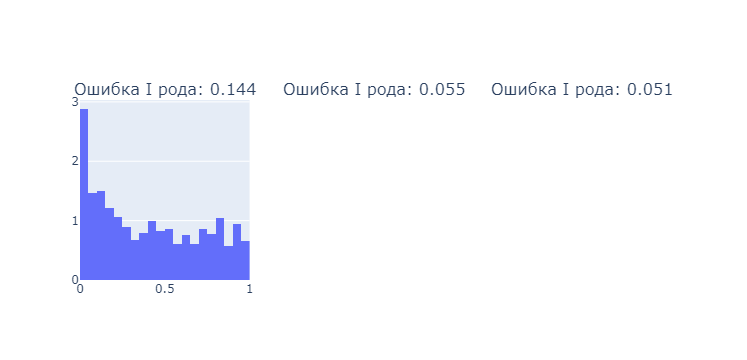

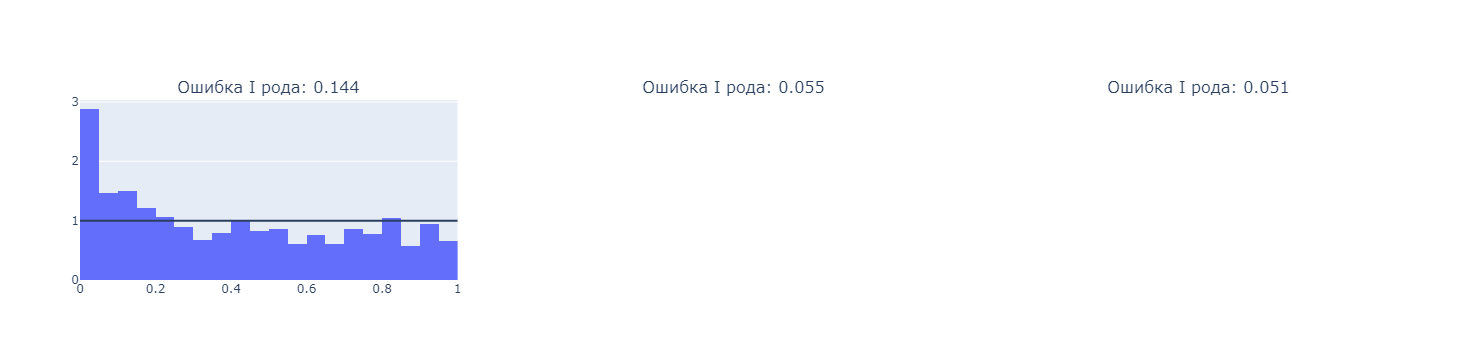

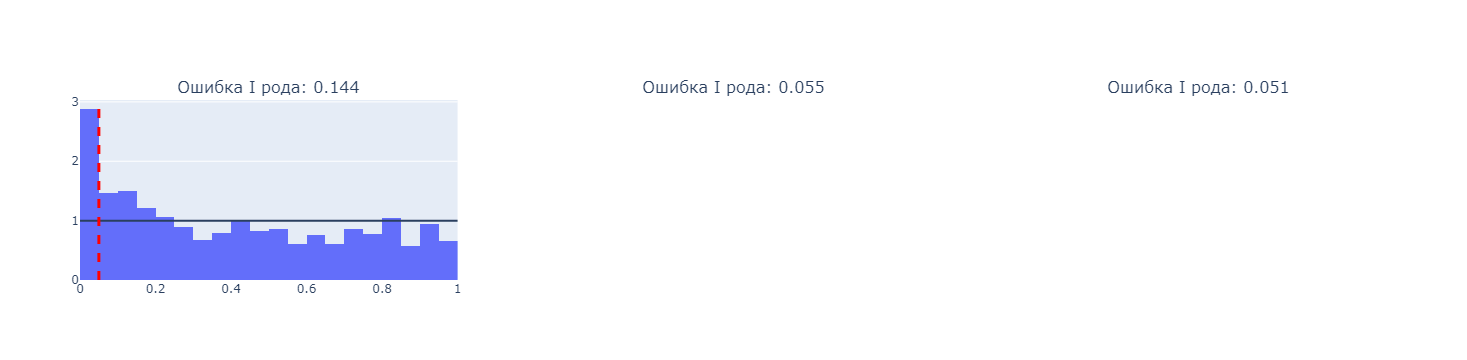

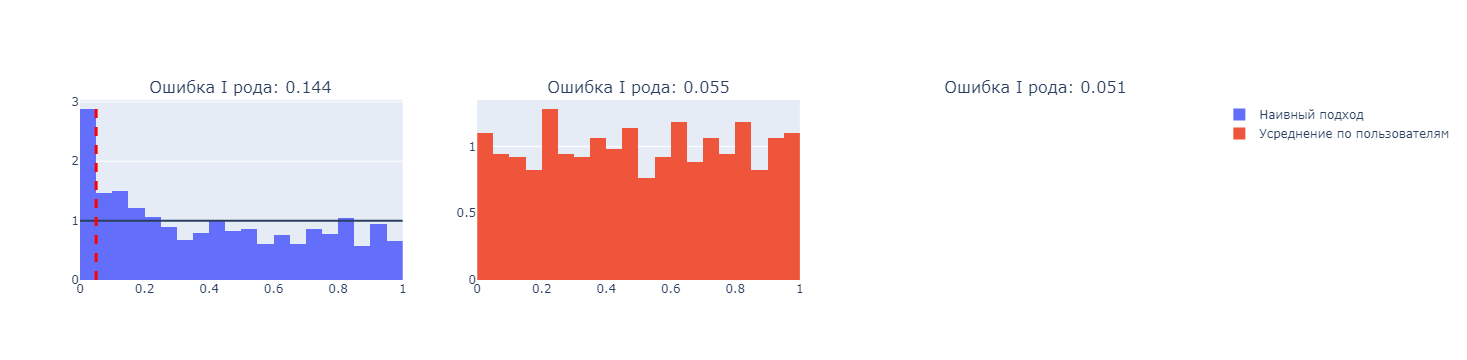

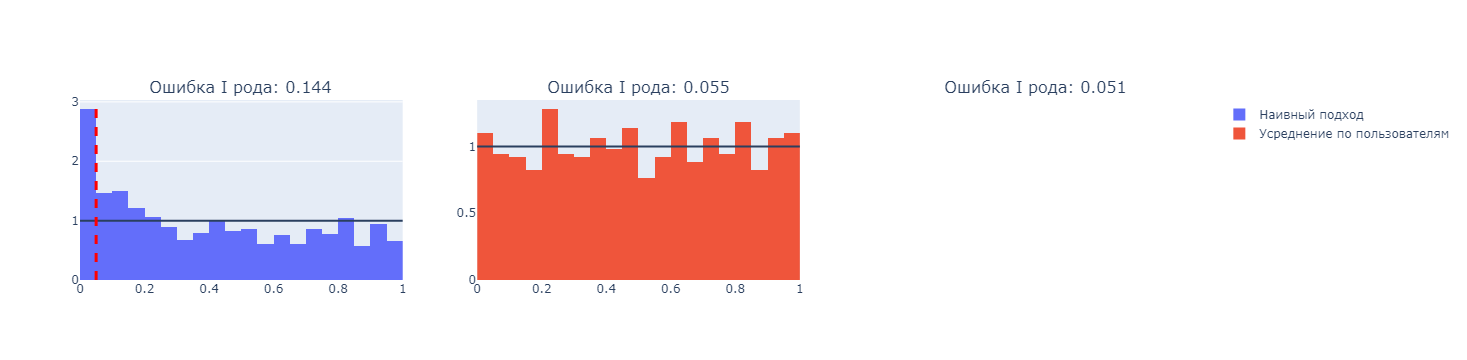

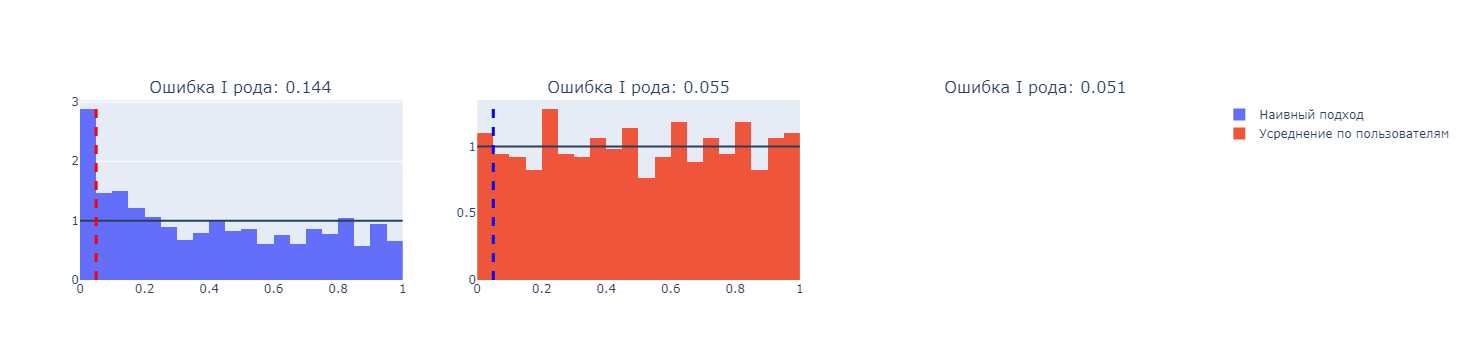

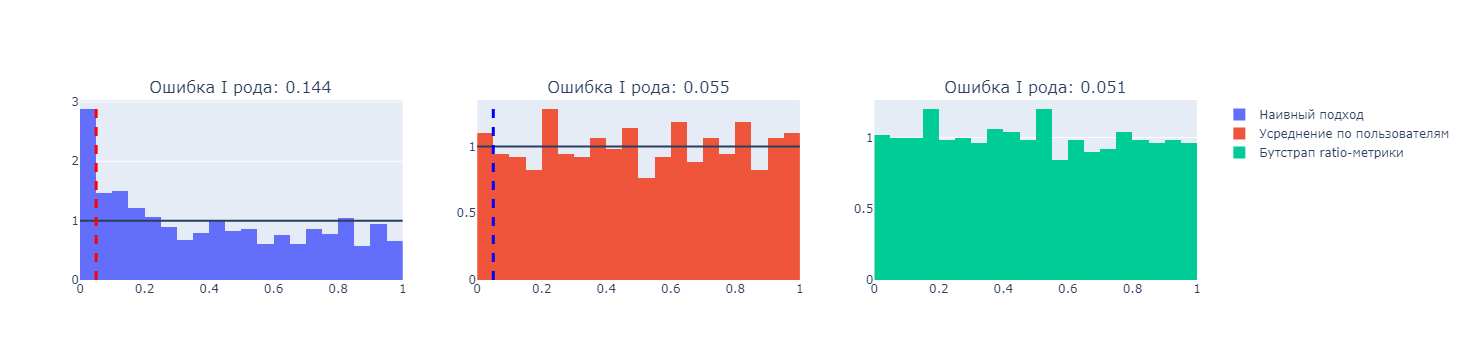

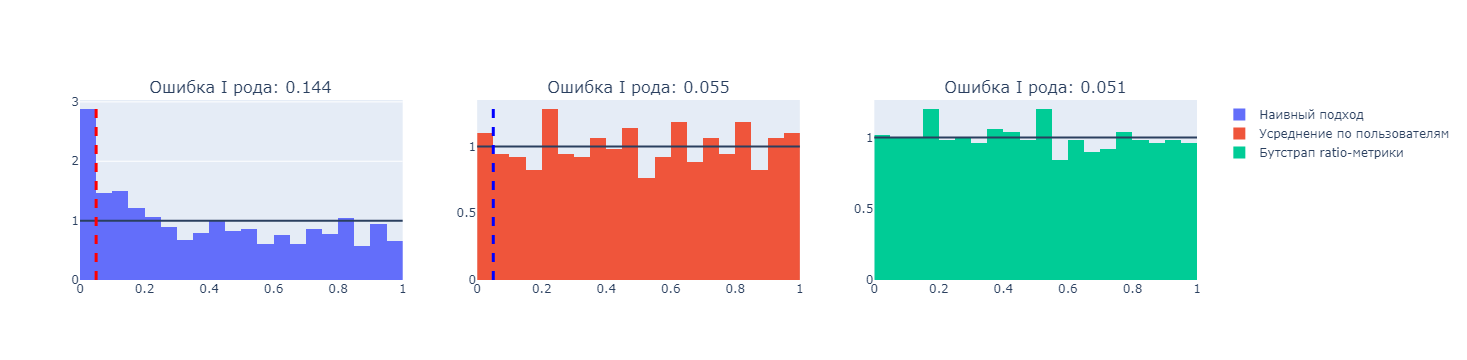

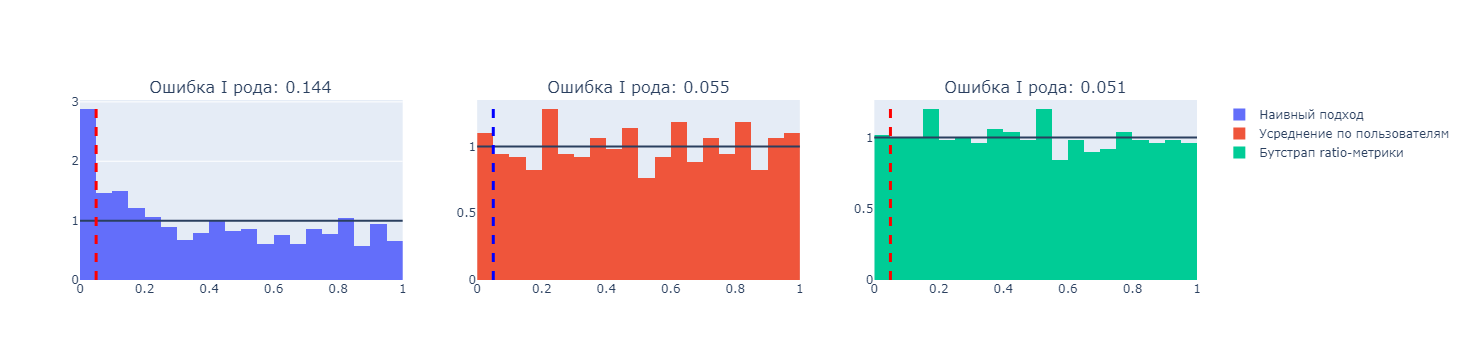

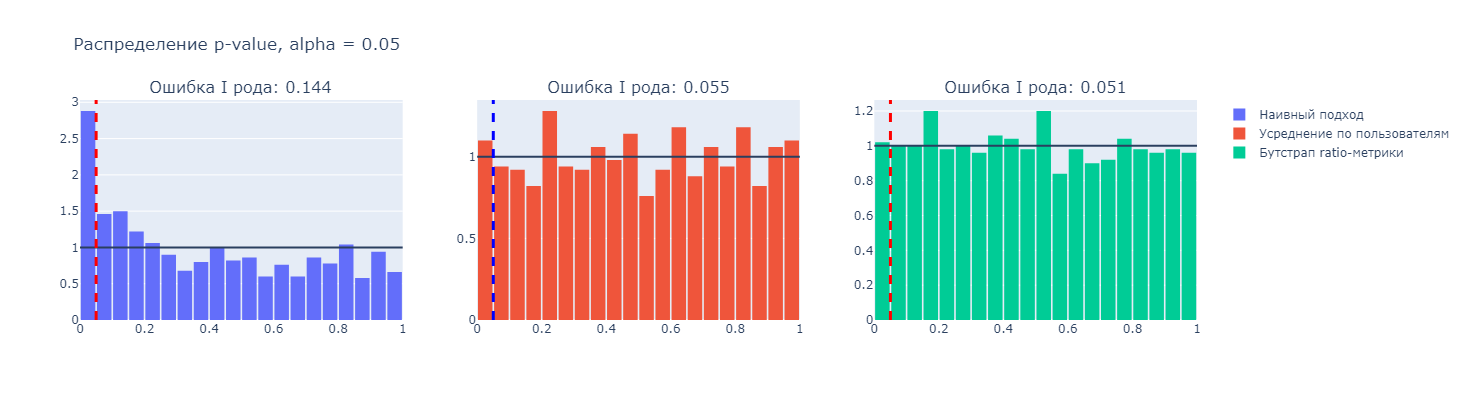

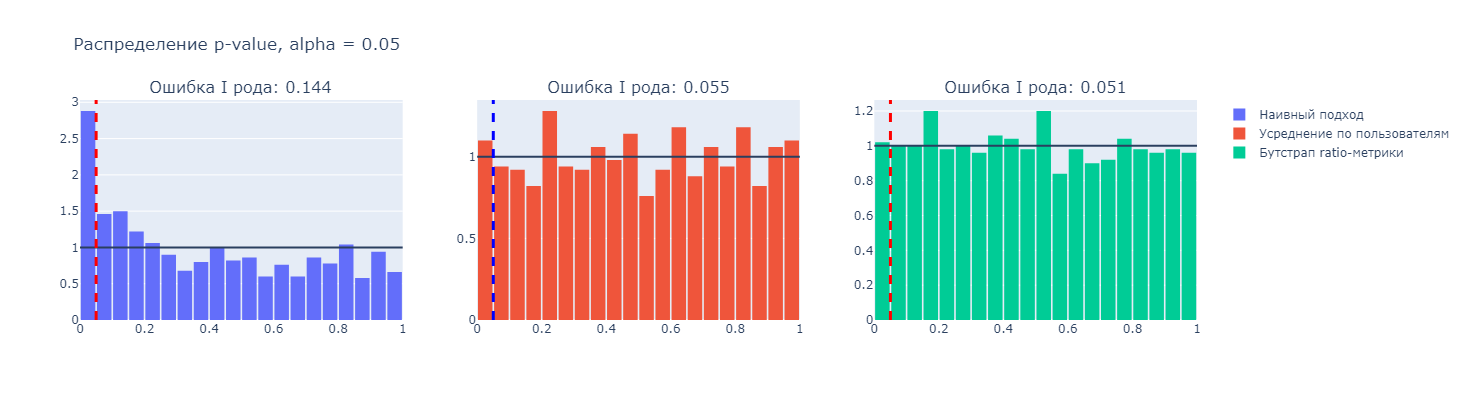

In [19]:
fig = make_subplots(rows=1, cols=3, subplot_titles=[f"Ошибка I рода: {np.mean((np.array(p_values_naive)<0.05)*1):0.3f}", 
                                                   f"Ошибка I рода: {np.mean((np.array(p_values_avg)<0.05)*1):0.3f}",
                                                   f"Ошибка I рода: {np.mean((np.array(p_values_bootstrap)<0.05)*1):0.3f}"])

fig.add_trace(
    go.Histogram(x=p_values_naive,name='Наивный подход',histnorm='probability density',xbins=dict(
                        start=0,
                        end=1,
                        size=0.05)),
    row=1, col=1
)
fig.add_hline(y=1,row=1, col=1)
fig.add_vline(x=0.05, row=1, col = 1, line_width=3, line_dash="dash", line_color="red")



fig.add_trace(
    go.Histogram(x = p_values_avg, name='Усреднение по пользователям',histnorm='probability density',xbins=dict(
                        start=0,
                        end=1,
                        size=0.05)),
    row=1, col=2
)

fig.add_hline(y=1,row=1, col=2)
fig.add_vline(x=0.05, row=1, col = 2, line_width=3, line_dash="dash", line_color="blue")

fig.add_trace(
    go.Histogram(x = p_values_bootstrap, name='Бутстрап ratio-метрики',histnorm='probability density',xbins=dict(
                        start=0,
                        end=1,
                        size=0.05)),
    row=1, col=3
)

fig.add_hline(y=1,row=1, col=3)
fig.add_vline(x=0.05, row=1, col = 3, line_width=3, line_dash="dash", line_color="red")

fig.update_layout(title_text=f"""Распределение p-value, alpha = 0.05""",
                  bargap=0.1, height=400, width=1260)
fig.show()